In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.model_selection import cross_val_score
import re
from scipy import stats
from sklearn import svm
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import time
from datetime import datetime

In [3]:
df2 = pd.read_json("./dataset/train.json")

In [4]:
# Remove Outliers and Drop Empty Fields
newdf2 = df2[(df2['description'] != '') & (df2['description'] != '<p><a  website_redacted')]
newdf2 = newdf2[newdf2['display_address'] != '']
newdf2 = newdf2[newdf2['features'].str.len() > 0]
newdf2 = newdf2[(newdf2['interest_level'] == 'low') | (newdf2['interest_level'] == 'medium') | (newdf2['interest_level'] == 'high')]
newdf2 = newdf2[(newdf2['price'] != 10) & (newdf2['price'] != 0)]
newdf2 = newdf2[newdf2['latitude'] != 0]
newdf2 = newdf2[newdf2['longitude'] != 0]
newdf2 = newdf2[newdf2['photos'].str.len() > 0]
newdf2 = newdf2[newdf2['street_address'].str.len() > 0]

newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bathrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bedrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['latitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['longitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['price'])) < 3)]

In [5]:
def convert_dt_numeric(dataframe):
    datetime_float = []
    dct = {}
    indexes = list(dataframe.index.values.tolist())
    text_features_count = []
    
    for index in indexes:
        # counting total # of features
        if 'features' in dataframe:
            values = list(dataframe['features'][index])
            text_features_count.append(len(values))
        
        # converting time to float
        if 'created' in dataframe:
            datetime_obj = datetime.strptime(dataframe['created'][index], '%Y-%m-%d %H:%M:%S') 
            datetime_sec = time.mktime(datetime_obj.timetuple())
            datetime_float.append(datetime_sec)
    #     Convert float to datetime obj
    #     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
    #     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
    #     print(type(datetime_sec)) // float
    # dct
    if 'features' in dataframe:
        dataframe['text_features_count'] = text_features_count
    if 'created' in dataframe:
        dataframe['datetime_float'] = datetime_float

    # label interest_level => row : 2, medium : 1, high : 0
    if 'interest_level' in dataframe:
        lb_make = LabelEncoder()
        dataframe["interest_level_code"] = lb_make.fit_transform(dataframe["interest_level"])
    
    # Count total # of photos for each listing
    if 'photos' in dataframe:
        dataframe['num_photos'] = dataframe['photos'].apply(len)
    if 'bathrooms' and 'bedrooms' in dataframe:
        dataframe['total_rooms'] = dataframe['bathrooms'] + dataframe['bedrooms']

In [6]:
convert_dt_numeric(newdf2)

# Support Vector Machine 

    - Kernerl: Gaussian radial basis function (RBF)
    - Reason: It is a general-purpose kernel; used when there is no prior knowledge about the data.

In [7]:
df_numeric = newdf2.copy(deep=True)
df_numeric.drop(['latitude', 'building_id','created','features', 'interest_level','longitude', 'description', 'display_address', 
                      'listing_id', 'manager_id', 'photos', 'street_address'], axis = 1, inplace= True)

# plt.figure(figsize=(7,4))
# sns.heatmap(df_numeric.corr(), annot=True, cmap='cubehelix_r')
# plt.show()

In [8]:
testDT = pd.read_json("./dataset/test.json") # no interest level. Original 

## 1) Performance

The value of gamma and C should not be very high because it leads to the overfitting or it shouldn’t be very small (underfitting). Thus we need to choose the optimal value of C and Gamma in order to get a good fit.

The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set

The C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.

StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set


### 1.1) Test Dataset

In [58]:
# Train model with trainset first and make prediction based on trainset
X = df_numeric[['bathrooms','bedrooms','price']]
y = df_numeric[['interest_level_code']]
test_X = testDT[['bathrooms','bedrooms','price']]

# C = [0.001, 0.01, 0.1, 1, 10], gammas = [0.001, 0.01, 0.1, 1]
model = svm.SVC(C=0.01, probability = True)
model.fit(X, np.ravel(y))
model_scores = model.score(X, y)
print("Accuracy: %0.2f (+/- %0.2f)" % (model_scores.mean(), model_scores.std() * 2))

Accuracy: 0.67 (+/- 0.00)


In [59]:
predicted = model.predict(test_X) # output: [?, ?, ?]
probs_labels = model.predict_proba(test_X) # output: [[p1,p2,p3],[p1,p2,p3]...]

df_with_ps = testDT.copy(deep=True)
df_with_ps['p_0_interest'] = [probs[0] for probs in probs_labels]
df_with_ps['p_1_interest'] = [probs[1] for probs in probs_labels]
df_with_ps['p_2_interest'] = [probs[2] for probs in probs_labels]
df_with_ps['predicted'] = predicted

df_with_ps.rename(columns={'p_0_interest': 'high', 'p_1_interest': 'medium', 'p_2_interest': 'low'}, inplace=True)
df2csv = df_with_ps[['listing_id', 'high', 'medium','low']]
df2csv.to_csv('kaggle-test_improved_C_001_Gamma_SCALE.csv', encoding='utf-8', index=False)

### 1.2) K-Fold Cross-validation datasets

In [88]:
initial_train_X = df_numeric[['bathrooms','bedrooms','price']]
initial_train_y = df_numeric[['interest_level_code']]
test_X = testDT[['bathrooms','bedrooms','price']]

model = svm.SVC(C=0.001, gamma='scale', probability = True)
kf = KFold(n_splits=5, shuffle=False) # shuffle=False => keep the order of dataset consistent
# skf = StratifiedKFold(n_splits=10)
scores = []

# for train_index, test_index in skf.split(initial_train_X,initial_train_y):
for train_index, test_index in kf.split(initial_train_X):
    X_train, X_test = initial_train_X[train_index[0]:train_index[-1]], initial_train_X[test_index[0]:test_index[-1]]
    y_train, y_test = initial_train_y[train_index[0]:train_index[-1]], initial_train_y[test_index[0]:test_index[-1]]
    print("done splitting")
    
    model.fit(X_train, np.ravel(y_train))
    scores.append(model.score(X_test, y_test))
    print("done fitting")
    
# print("Accuracy:",np.mean(scores)," +/-",np.std(scores)*2)

done splitting
done fitting
done splitting
done fitting
done splitting
done fitting
done splitting
done fitting
done splitting
done fitting


In [102]:
predicted = model.predict(test_X) 
probs_labels = model.predict_proba(test_X) # output: [[p1,p2,p3],[p1,p2,p3]...]

df_with_ps = testDT.copy(deep=True)
df_with_ps['p_0_interest'] = [probs[0] for probs in probs_labels]
df_with_ps['p_1_interest'] = [probs[1] for probs in probs_labels]
df_with_ps['p_2_interest'] = [probs[2] for probs in probs_labels]
df_with_ps['predicted'] = predicted

df_with_ps.rename(columns={'p_0_interest': 'high', 'p_1_interest': 'medium', 'p_2_interest': 'low'}, inplace=True)
df2csv = df_with_ps[['listing_id', 'high', 'medium','low']]
df2csv.to_csv('kaggle2test.csv', encoding='utf-8', index=False)

Confusion matrix, without normalization
[[   0  817    0]
 [   0 6901    0]
 [   0 2485    0]]
Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


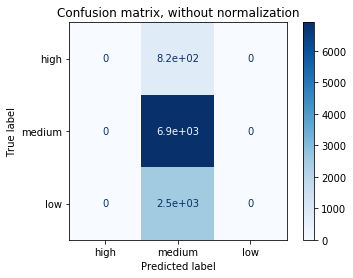

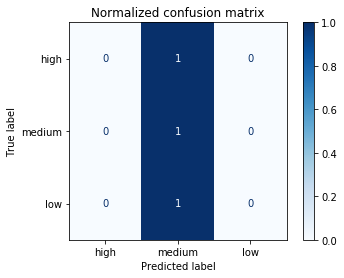

In [103]:
from sklearn.metrics import plot_confusion_matrix


# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=["high", "medium", "low"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


plt.show()
    

In [105]:
from sklearn.metrics import log_loss

probs_labels = model.predict_proba(X_test) # output: [[p1,p2,p3],[p1,p2,p3]...]
log_loss(y_test, probs_labels)

1.0077932321670278